In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [4]:
import numpy as np

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
abalone = fetch_ucirepo(id=1) 
  
# data (as pandas dataframes) 
X = abalone.data.features
y = abalone.data.targets

#X = pd.get_dummies(X, columns=['Sex'])
X = X.drop(columns=['Sex'])

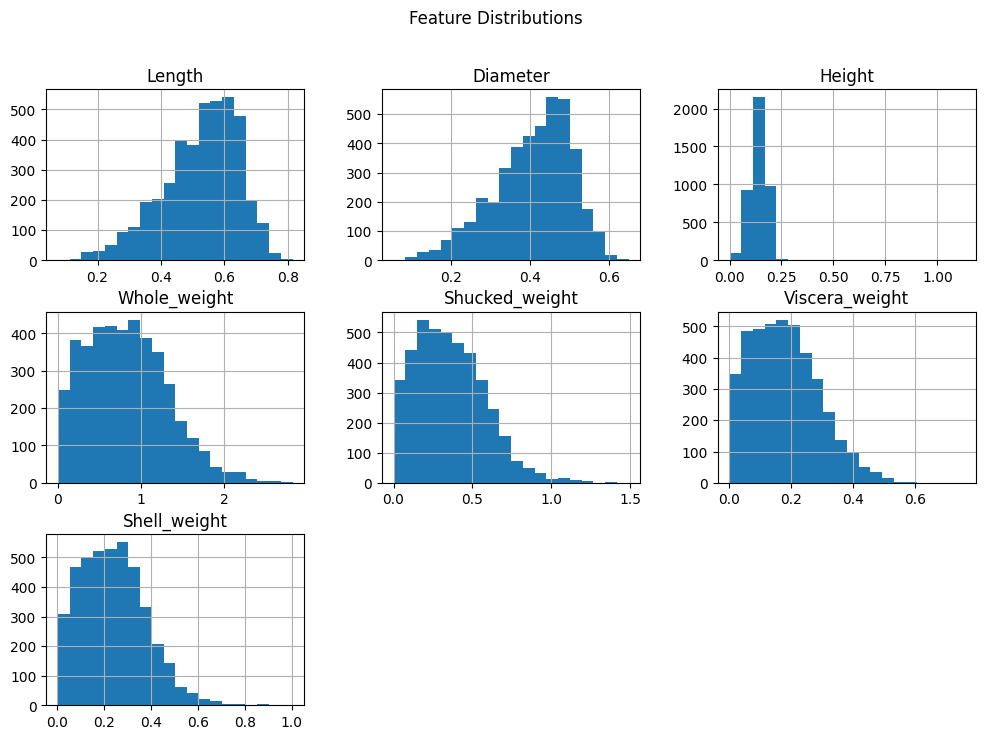

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

X.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

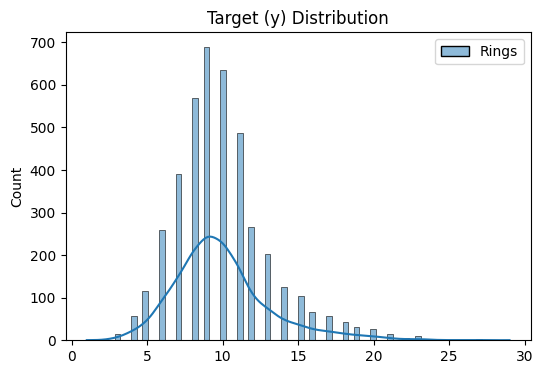

In [6]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

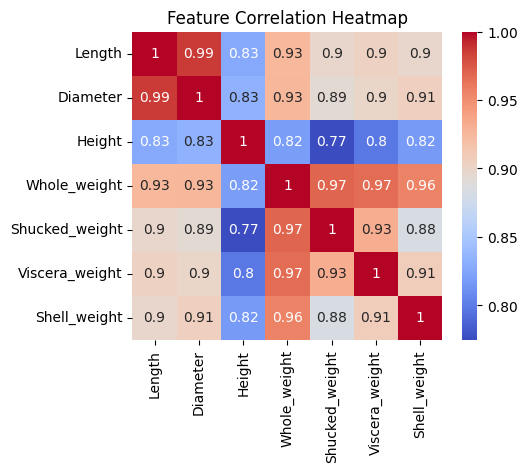

In [7]:
plt.figure(figsize=(5, 4))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [8]:
X = X.values.astype(float)
y = np.array(y).astype(np.float32).reshape(-1)

In [9]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=10, n_chains=4, ndpost=1000, nskip=1000, n_trees=100, n_jobs=-2)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.118704                 1.040674             1.270679   
1                  1.034944                 1.059126             1.062570   
2                  1.035816                 1.228857             1.302101   
3                  1.150734                 1.105708             1.083957   
4                  1.021050                 1.089730             1.139742   
5                  1.131877                 1.148579             1.163200   
6                  1.089811                 1.126142             1.101995   
7                  1.099072                 1.025754             1.194673   
8                  1.079561                 1.077962             1.155260   
9                  1.144295                 1.063380             1.207629   
mean               1.090586                 1.096591             1.168180   
std                0.047285              

In [10]:
rhat_df.to_csv("results/real1_Abalone_rhat.csv", index=False)

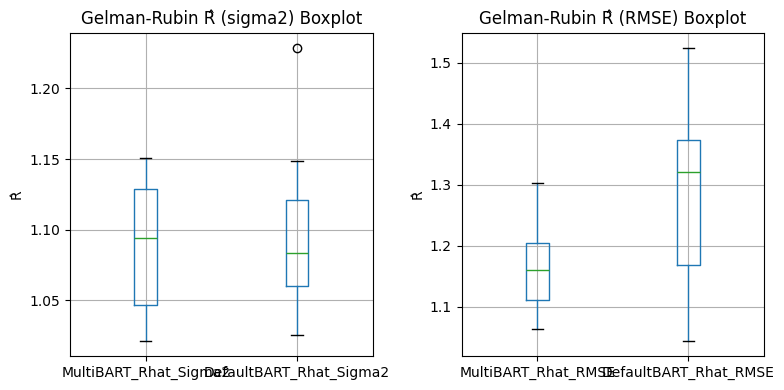

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

test_mse:
      bart_mtmh      bart       btz        rf       xgb
0      4.912698  4.785035  4.903378  4.791655  5.722874
1      4.747219  4.772575  4.814521  4.574730  5.348410
2      5.362464  5.341684  5.341948  5.399027  5.810473
3      4.611325  4.396349  4.516953  4.645710  5.385919
4      4.295983  4.386252  4.469932  4.558238  5.046336
5      5.141440  5.260020  5.142657  5.052298  5.874977
6      5.199450  5.007573  4.866876  4.946810  5.660102
7      5.384970  5.320975  5.287504  5.139162  5.571136
8      4.907956  5.019699  4.828933  4.887725  5.738235
9      5.203922  5.233226  5.243740  5.280333  5.807626
mean   4.976743  4.952339  4.941644  4.927569  5.596609
std    0.349959  0.358782  0.307377  0.292084  0.261880



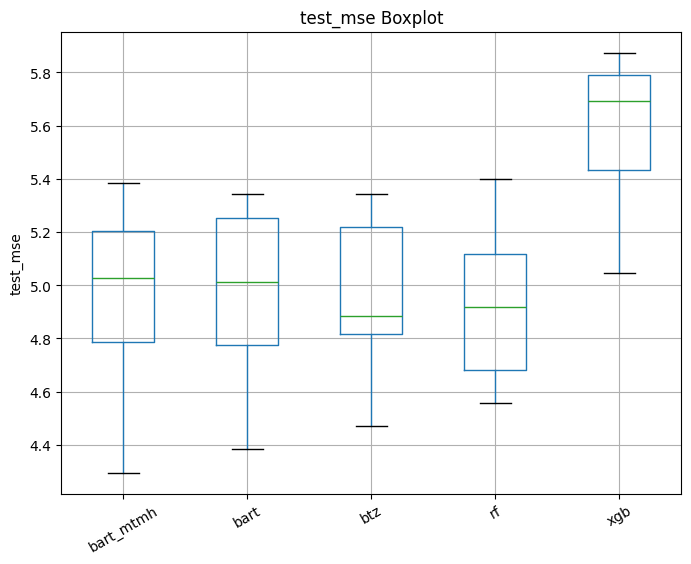

train_mse:
      bart_mtmh      bart       btz        rf       xgb
0      3.252209  3.680247  3.907227  0.679427  0.542755
1      3.354718  3.785308  3.998078  0.683244  0.606606
2      3.234012  3.600360  3.762385  0.639765  0.543232
3      3.273435  3.769038  3.964890  0.677036  0.545936
4      3.506264  3.883342  4.066865  0.681703  0.621954
5      3.172575  3.526894  3.831447  0.647193  0.533894
6      3.222539  3.647211  3.914979  0.680122  0.566025
7      3.157861  3.629868  3.772048  0.656752  0.540149
8      3.296513  3.620005  3.909686  0.674107  0.535856
9      3.148401  3.585788  3.734415  0.667631  0.549909
mean   3.261853  3.672806  3.886202  0.668698  0.558632
std    0.107376  0.108370  0.109325  0.015522  0.030849



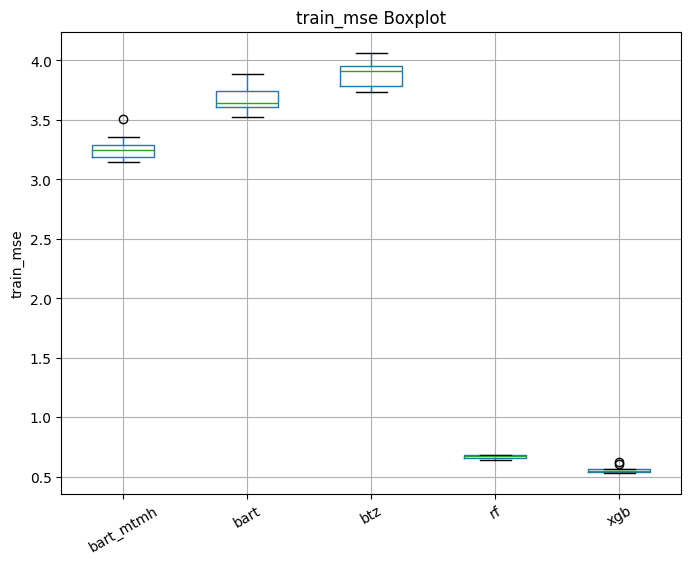

pi_length:
      bart_mtmh      bart       btz
0      7.921738  8.092814  8.321031
1      8.038117  8.159687  8.309382
2      7.926519  7.985764  8.169294
3      8.002783  8.203139  8.280876
4      8.232325  8.286541  8.407695
5      7.836938  7.971134  8.260305
6      7.901545  8.081277  8.300514
7      7.896087  8.067723  8.252511
8      7.994392  8.019718  8.307041
9      7.892922  8.029557  8.148610
mean   7.964336  8.089735  8.275725
std    0.111962  0.100251  0.074897



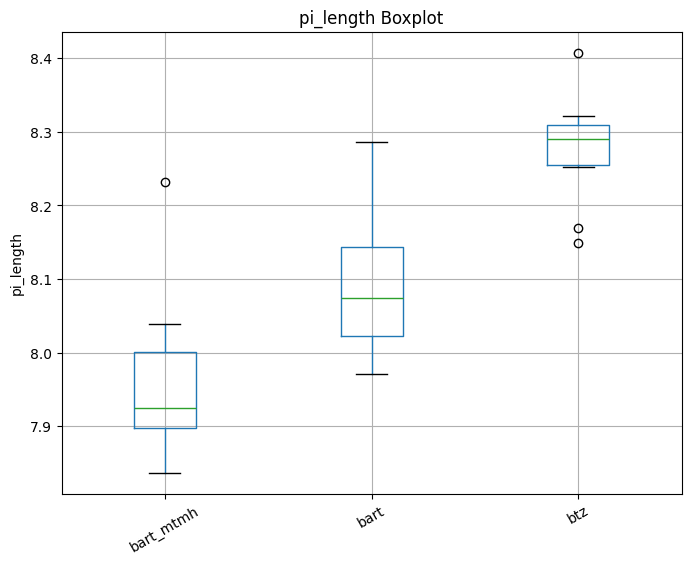

coverage:
      bart_mtmh      bart       btz
0      0.931100  0.933971  0.946411
1      0.931100  0.929187  0.935885
2      0.923445  0.924402  0.926316
3      0.931100  0.940670  0.941627
4      0.947368  0.948325  0.940670
5      0.917703  0.922488  0.930144
6      0.912919  0.921531  0.932057
7      0.920574  0.919617  0.923445
8      0.935885  0.933014  0.938756
9      0.929187  0.926316  0.922488
mean   0.928038  0.929952  0.933780
std    0.009871  0.009165  0.008192



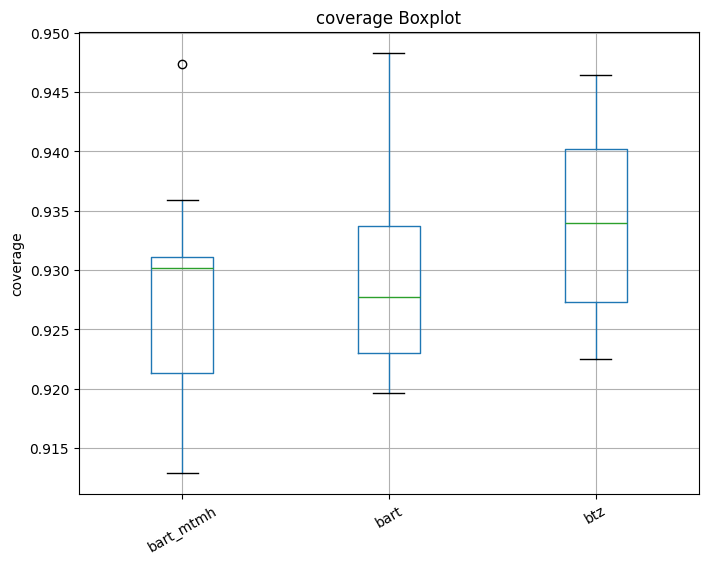

train_time:
       bart_mtmh        bart        btz        rf       xgb
0     215.288010   38.889176  68.728065  2.383583  0.354733
1     214.257779   38.397090  59.670913  4.176161  0.354916
2     213.339171   38.655061  56.920488  5.882423  0.730743
3     212.237359   38.889403  51.170847  7.908473  0.570828
4     215.688323   39.317759  71.172140  1.961396  0.388994
5     214.241644   39.833674  68.696299  2.259743  0.369131
6     213.770228   38.387276  57.612471  5.353535  0.619891
7     217.236290  101.092985  26.749208  1.584862  0.236510
8     212.345381   37.889519  50.812864  7.957841  1.119893
9     212.379338   38.442816  50.304210  8.378694  0.905563
mean  214.078352   44.979476  56.183751  4.784671  0.565120
std     1.633236   19.723701  12.945427  2.687280  0.282843



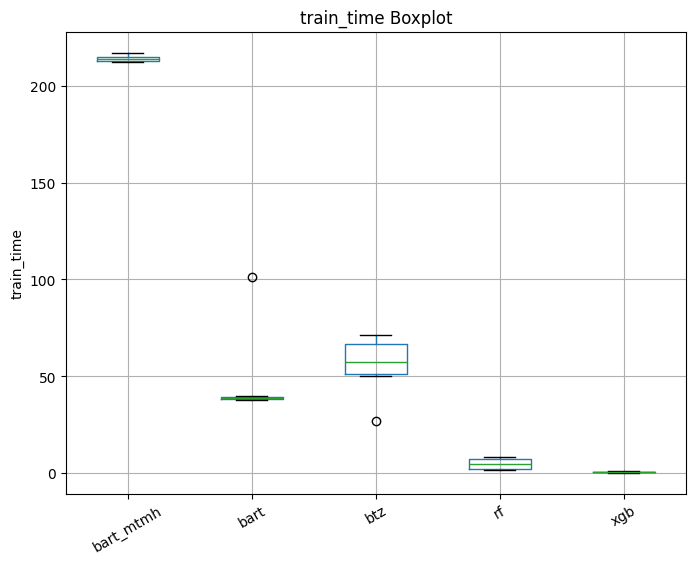

In [9]:
import matplotlib.pyplot as plt
import comparison
import pandas as pd

mse_results = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=1000, n_post=1000, n_trees=100, n_jobs=-2)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [10]:
for k, v in mse_results.items():
    csv_name = f"results/real1_Abalone_{k}.csv"
    v.to_csv(csv_name, index=False)

## Multi-tries

In [ ]:
from multi_tries import multi_tries_performance
import pandas as pd

csv_path = "results/real1_Abalone_tries.csv"
existing_df = None

if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)

df = multi_tries_performance(
    X, y,
    multi_tries_list=[1, 5, 10, 50],
    n_runs=10, n_chains=4,
    ndpost=1000, nskip=1000, n_trees=100, n_jobs=-2
)

if existing_df is not None:
    df = pd.concat([existing_df, df], ignore_index=True)
    df = df.sort_values(by='multi_tries', ascending=True).reset_index(drop=True)

df.to_csv("results/real1_Abalone_tries.csv", index=False)

In [ ]:
print(df)